# Connecting Snow Depth Models to Moose Survey Conditions
T. Brinkman (University of Alaska Fairbanks), K. Seaton (Ruby Moon Consulting), A. Reinking and G. Liston (Colorado State University)


## Introduction
This is a Python Jupyter Notebook housed in a Datacamp Workspace. It was created to demonstrate the benefits of a notebook platform for improving collaboration on analyses. 

Key features include:
- **Access big data:** Collaborators can connect to the same large library of raster data from any computer. NOTE: this demo uses raster data uploaded directly to the Datacamp Workspace, which provides up to 5GB of space. However, the notebook also allows connections to servers hosting large raster libraries using *integrations*, as we intend in future versions.
- **Access cloud drives:** Survey data and shapefile are uploaded from Dropbox
- **Transparent analyses:** The notebook contains all Python code required to run the analysis. No hidden details.
- **Interactive:** The data processing and analyses are done 'live' in the document and can be re-run by the user. Alternate datasets can be uploaded to answer other questions.
- **Cloud-hosted:** The Datacamp Workspace platform ensures a common environment, software versions and installation
- **Versioning:** Datacamp provides a notebook history, and also connects with GitHub.
- **Collaborative:** Invited datacamp members can view or edit private notebooks in a workspace, allowing real-time collaboration on code editing. Public workbooks are visible to anyone as read-only notebooks.

## Background
In Alaska, estimates of moose population size are most often obtained using an aerial survey platform. Visibility of moose in a given area, among different habitats, is key to the accuracy of these estimates. Snow must be deep enough to provide a white backdrop for moose to be seen from an airplane. Biologists primarily launch (or don't launch) a survey based on the depth of snow. In this study, we investigate the use of a weather model called SNOWMODEL to distinguish between poor and adequate snow conditions for conducting moose surveys. Accruate modeling of these survey conditions would provide quantification of survey conditions in Alaska over time and space, and allow us to understand the effects of a shrinking winter on wildlife management. 

![GoodPoorDetection](GoodPoorDetection.PNG)

## Preparing the Data

### Install Packages
The Datacamp Workspace allows the user to import libraries that are not pre-loaded, like the statistics package pymer 4. I use a pip install to load it into the notebook:

In [2]:
!pip install pymer4

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.9/215.9 kB 31.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.1/340.1 kB 49.1 MB/s eta 0:00:00
  Created wheel for rpy2: filename=rpy2-3.5.10-cp38-cp38-linux_x86_64.whl size=330708 sha256=c438baeca15517579a1bb1d17f18126b36bb8aa0741dedff36e02b42e3949a1f
  Stored in directory: /home/repl/.cache/pip/wheels/24/1d/4f/0ab1283b3801c003e2b31ae6fe30f545c0c89c83a741c1f5e4
Successfully built rpy2


Next, I import several libraries for this demonstration. All but pymer4 are pre-loaded by Datacamp. These are not installed locally- just imported into the notebook.

In [3]:
# load libraries
import pandas as pd
import geopandas as gpd
import shapely
import fiona
import os
import os.path
import rasterio
from rasterio import plot as rasterplot
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
from pymer4.models import Lmer

* Project '~/' loaded. [renv 0.15.4]


Warning message:
In file(file, "rt") :
  cannot open file '/usr/lib/R/doc/CRAN_mirrors.csv': No such file or directory


### Variables
Here we connect variables to various files and folders. The moose survey data .csv and raster mask shapefile are imported from a Dropbox account using the wget command and a file-specific link from Dropbox. [This article]([https://workspace-docs.datacamp.com/integrations/dropbox](https://uidfcba.github.io/570a/html/Module1/notebooks/intro2nb.html)) about Jupyter Notebooks explained how to set up the connection.

In [4]:
# variables
# coordinate system of raster data in EPSG format
snowcrs = "EPSG:3338" # Albers 154, NAD 83

# moose survey data
surveyYears = 'SurveyYears_01Nov.csv' # 1 row for each survey year/study area meeting criteria. Using std 01 Nov date for all
dpxSurveyLink = 'wget https://www.dropbox.com/s/wuryii2f2igajdt/SurveyYears_01Nov.csv' # Dropbox link

# mask shapefile name
surveyMasks = 'SurveyMasks2022.zip' # zipped shapefile with survey footprints. MaskID column links to MaskID column in surveyYears
dpxMaskLink = 'wget https://www.dropbox.com/s/r30y9ym1td0tk9d/SurveyMasks2022.zip' # Dropbox link

# path to raster library
snowRaster = 'snowdata/' # snow depth spatial predictions for 1980-2020 on Nov 01 were pre-loaded into this workbook for analysis
# application of this workbook can be expanded to other dates, study areas if data are loaded onto an image server and linked here

# output paths
out_json = 'output/output.json' # JSON export of geodatabase used in analysis 
out_csv = 'output/output.csv' # csv file with average snow depth appended


### Moose Survey Data
For this analysis, we examine the relationship between survey execution/cancellation and snow depth at the beginning of moose survey season (01 Nov). This file could be modified or replaced to answer different questions. In this demonstration, only snow depth rasters for 01 Nov, 1980 - 2020 in the 6 areas have been uploaded to the workspace.

In [5]:
# load moose survey data
if os.path.isfile(surveyYears): # if already in directory, remove and reload
    os.remove(surveyYears)

os.system(dpxSurveyLink) # upload csv from Dropbox

--2023-03-15 13:44:04--  https://www.dropbox.com/s/wuryii2f2igajdt/SurveyYears_01Nov.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/wuryii2f2igajdt/SurveyYears_01Nov.csv [following]
--2023-03-15 13:44:08--  https://www.dropbox.com/s/raw/wuryii2f2igajdt/SurveyYears_01Nov.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc25a5b0d320ed679cecb2202998.dl.dropboxusercontent.com/cd/0/inline/B4RoimFJeLg3xBatgJB1q4h3a95WBIu_zLadMcnyo4fXQyn1AENI8c_m7QXvhV5lMSjigJV_iOWCVPIWfhit19tjlEecMsI9aGHDYMDT8X0P0NpY_ILyH2KGmMeCbkdi55vMl82mWcHnfwaaOpMl5zWKVh3DUQ16PC6AIo_MP3VZjw/file# [following]
--2023-03-15 13:44:08--  https://uc25a5b0d320ed679cecb2202998.dl.dropboxusercontent.com/cd/0/inline/B4RoimFJeLg3xBatgJB1q4h3a95WBIu_zLadMcnyo4fXQyn1AENI8

0

In [11]:
# make dataframe of survey data
df = pd.read_csv(surveyYears)

# convert input dates to datetime objects
df.Date = pd.to_datetime(df.Date)

# format path to snow raster, append as column snowRast in df
df['snowRast'] = ""

for i in df.index:
    df['snowRast'][i] = snowRaster + 'GMU_{0}_180m_snod_{1}_{2}_{3}.tif'.format(df.GMU.values[i], df.Date.dt.year.values[i], df.Date.dt.month.values[i], str(df.Date.dt.day.values[i]).zfill(2))

df['mnDepthCm'] = np.nan # column for average snow depth
    
df.head(5)

,ObsID,MaskID,Date,GMU,Surveyed,Year,StudyArea,snowRast,mnDepthCm
0,1,E25D_2,1988-11-01,25D,0,1988,25DE,snowdata/GMU_25D_180m_snod_1988_11_01.tif,NaN
1,3,E25D_2,1990-11-01,25D,0,1990,25DE,snowdata/GMU_25D_180m_snod_1990_11_01.tif,NaN
2,12,E25D_1,2002-11-01,25D,0,2002,25DE,snowdata/GMU_25D_180m_snod_2002_11_01.tif,NaN
3,13,E25D_1,2003-11-01,25D,0,2003,25DE,snowdata/GMU_25D_180m_snod_2003_11_01.tif,NaN
4,20,E25D_1,2011-11-01,25D,0,2011,25DE,snowdata/GMU_25D_180m_snod_2011_11_01.tif,NaN


The data frame contains 1 row for each survey opportunity (i.e., observation). An opportunity is a specific survey year in a specific study area where a moose survey was either successfully conducted, or cancelled because snow conditions were not adequate. The data do not include surveys cancelled for other reasons.

**Explanation of Data Columns:**
1. **ObsID:** A unique ID for each observation. This is useful when identifying outliers
2. **MaskID:** Survey boundaries change from year to year, study area to study area. This is a unique ID for the survey boundary for that survey opportunity.
3. **Date:** The date of the SNOWMODEL snow raster to retrieve. Because cancelled surveys have no start date, we use a common date of 01 Novmeber to analyze snow conditions at the onset of the survey season for all observations.
4. **GMU:** The snow raster GMU to use for analysis.
5. **Surveyed:** The response variable for logistic regression analysis. A '1' means a survey was conducted. A '0' means a survey was scheduled, but cancelled because of inadequate snow conditions.
6. **Year:** The year of the survey opportunity. Used as a repeated measure. We expect snow conditions may be simlar among GMUs for the same date, year combinations.
7. **StudyArea:** The survey area considered for a survey opportunity. Used as a random effect. Note that this differs from GMU for 25D, where the raster encompasses both the 25D East (25DE) and 25D West (25DW) study areas.
8. **SnowRast:** The name of the SNOMODEL raster to use in analysis.
9. **mnDepthCm:** Column for storing mean snow depth in cm.

### Survey Area Masks
Next, we upload the shapefile containing polygons for the survey areas as a Pandas geodatabase. Survey boundaries changed over the years and so there are several for each study area.

In [12]:
# load mask shapefile
if os.path.isfile(surveyMasks): # delete any existing file
    os.remove(surveyMasks)

os.system(dpxMaskLink) # get zipped shapefile from Dropbox

--2023-03-15 14:03:06--  https://www.dropbox.com/s/r30y9ym1td0tk9d/SurveyMasks2022.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/r30y9ym1td0tk9d/SurveyMasks2022.zip [following]
--2023-03-15 14:03:10--  https://www.dropbox.com/s/raw/r30y9ym1td0tk9d/SurveyMasks2022.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9cbe25aaa3daaf5ce84768abe4.dl.dropboxusercontent.com/cd/0/inline/B4T9R4eNRQfk6x5SlkI3vkIgQRhb-OwbZMOjm2I1_3IcabnmNFkMLaiQWoW9TvWjL6bG0zpO-OSpLtSCkY3hI2mRAH2BqkJPnHbtPu9vIL1lwi4pFTiyNVias9SCMZWkb9oigz4BI6WxWUM3l4AVCMd79xheILeobUP17C4TUxID4Q/file# [following]
--2023-03-15 14:03:13--  https://uc9cbe25aaa3daaf5ce84768abe4.dl.dropboxusercontent.com/cd/0/inline/B4T9R4eNRQfk6x5SlkI3vkIgQRhb-OwbZMOjm2I1_3IcabnmNFkMLaiQWoW

0

In [13]:
# make pandas geoDataFrame from zipped shapefile
zipfile = surveyMasks
m = gpd.read_file(zipfile)

# check crs
if m.crs != snowcrs: # if the shapefile is not in Albers 154 NAD83
    m = m.to_crs(snowcrs) # re-project to Albers 154 NAD83
print(m.crs) # check

m.head(5)

epsg:3338


,SurveyArea,MaskID,Shape_Leng,Shape_Area,geometry
0,14A,A14_1,6.234783e+05,7.404782e+09,"POLYGON ((298174.895 1367464.716, 298497.031 1..."
1,14A,A14_2,1.082984e+06,4.249634e+09,"POLYGON ((197322.003 1316128.772, 197726.749 1..."
2,15A,A15_1,3.971228e+05,2.546409e+09,"POLYGON ((180063.615 1224392.040, 179943.724 1..."
3,15A,A15_2,3.135962e+05,2.041705e+09,"MULTIPOLYGON (((207758.640 1176678.361, 208671..."
4,15A,A15_3,4.164785e+05,2.135583e+09,"MULTIPOLYGON (((162661.400 1203812.052, 162578..."


The "MaskID" column links a survey opporunity with the appropriate survey area. I merged survey data with the survey mask. For larger data frames, it might be more efficient to do the merge within the loop (below).

In [14]:
# merge survey data and mask
tempdf = pd.merge(df, m[['MaskID','geometry']], on = 'MaskID', how = 'left')
gdf = gpd.GeoDataFrame(tempdf, crs = snowcrs, geometry = tempdf['geometry']) # make it a geodataframe
gdf.head(5)

,ObsID,MaskID,Date,GMU,Surveyed,Year,StudyArea,snowRast,mnDepthCm,geometry
0,1,E25D_2,1988-11-01,25D,0,1988,25DE,snowdata/GMU_25D_180m_snod_1988_11_01.tif,NaN,"MULTIPOLYGON (((448483.500 1854013.000, 448541..."
1,3,E25D_2,1990-11-01,25D,0,1990,25DE,snowdata/GMU_25D_180m_snod_1990_11_01.tif,NaN,"MULTIPOLYGON (((448483.500 1854013.000, 448541..."
2,12,E25D_1,2002-11-01,25D,0,2002,25DE,snowdata/GMU_25D_180m_snod_2002_11_01.tif,NaN,"POLYGON ((457098.375 1865986.687, 457668.041 1..."
3,13,E25D_1,2003-11-01,25D,0,2003,25DE,snowdata/GMU_25D_180m_snod_2003_11_01.tif,NaN,"POLYGON ((457098.375 1865986.687, 457668.041 1..."
4,20,E25D_1,2011-11-01,25D,0,2011,25DE,snowdata/GMU_25D_180m_snod_2011_11_01.tif,NaN,"POLYGON ((457098.375 1865986.687, 457668.041 1..."


### Snow Depth Rasters
The 01 November rasters for each sutdy area (40 years * 6 GMUs = 240 rasters) are loaded into a folder in the workspace called 'snowdata'. This is a subsample of the daily rasters in the full SNOWDATA raster library, which runs from 15 Oct - 15 Dec from 1980 - 2020 for each study area. Here is an example of snow depth (in Meters) predicted by SNOWMODEL for GMU 25D on 01 Nov 2002:

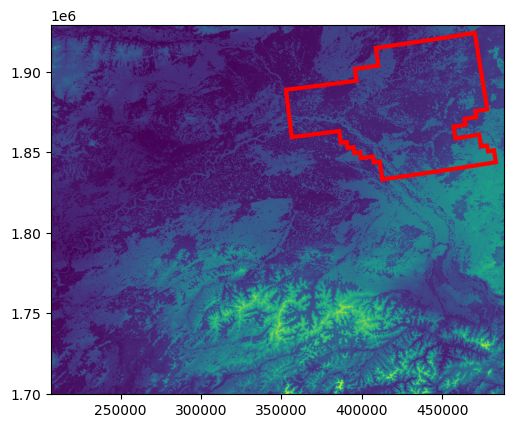

In [15]:
# example raster with mask overlay

# open raster
src = rasterio.open(gdf['snowRast'][3], 'r') # open raster connection using rasterio
src_extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
src_band = src.read(1)

# open mask shape
feature = Polygon(gdf['geometry'][3].exterior.coords, closed=True, fc='none', ec='red', lw=3)

# plot
fig, ax = plt.subplots()

# plot SNOWMODEL raster
rasterplot.show(src_band, extent = src_extent, ax=ax)

# plot mask
ax.add_patch(feature)


The next step is to loop through the surveys, connect to the snow rasters using **rasterio**, clip to study areas, calculate mean snow depth (cm) and save this value in the geodataframe. 

The rasters in this demonstration are housed in the workspace, so **this only takes 10 - 30 seconds to complete**. When the complete dataset is migrated to a server, processing time will increase. However, a much larger library will be available on the server for additional analyses. The complete 91GB library contains a raster SNOWMODEL prediction for snow depth for each day from 15 Oct to 15 Dec, 1980 - 2020 for all 7 study areas.

In [16]:
for i in gdf.index: # for each survey opportunity
    
    # get survey mask
    msk = gdf['geometry'][[i]]
    
    # delete temp raster
    if os.path.isfile('masked.tif'):
        os.remove('masked.tif')
    
    # mask the snow raster
    with rasterio.open(gdf['snowRast'][i], 'r') as src: # open the snow raster
        out_meta = src.meta # get metadata
        out_rast, out_trans = mask(src, msk, crop = True) # apply the mask
        out_profile = src.profile.copy() # copy the profile

        # update the profile
        out_profile.update({'width': out_rast.shape[2],
                            'height': out_rast.shape[1],
                            'transform': out_trans})

        # update the metadata
        out_meta.update({'driver': "GTiff", 
                         'height' : out_rast.shape[1],
                         'width' : out_rast.shape[2],
                         'transform': out_trans})
    
    # save masked raster to temp tif
    with rasterio.open('masked.tif', 'w', **out_meta) as dst:
        dst.write(out_rast)

    # open temp tif and get the mean snow depth
    with rasterio.open('masked.tif', 'r') as msnow: # open masked tif
        band = msnow.read(1, masked=True) # get the single band, excluding masked no data pixels
        rastMN = band.mean() # get mean value of pixels in meters
        #show(msnow)
        #print(rastMN*100) # save in cm

    # write mean snow depth to gdf
    gdf['mnDepthCm'][i] = rastMN*100

gdf.head(5)

,ObsID,MaskID,Date,GMU,Surveyed,Year,StudyArea,snowRast,mnDepthCm,geometry
0,1,E25D_2,1988-11-01,25D,0,1988,25DE,snowdata/GMU_25D_180m_snod_1988_11_01.tif,6.073834,"MULTIPOLYGON (((448483.500 1854013.000, 448541..."
1,3,E25D_2,1990-11-01,25D,0,1990,25DE,snowdata/GMU_25D_180m_snod_1990_11_01.tif,4.726004,"MULTIPOLYGON (((448483.500 1854013.000, 448541..."
2,12,E25D_1,2002-11-01,25D,0,2002,25DE,snowdata/GMU_25D_180m_snod_2002_11_01.tif,4.498883,"POLYGON ((457098.375 1865986.687, 457668.041 1..."
3,13,E25D_1,2003-11-01,25D,0,2003,25DE,snowdata/GMU_25D_180m_snod_2003_11_01.tif,3.772018,"POLYGON ((457098.375 1865986.687, 457668.041 1..."
4,20,E25D_1,2011-11-01,25D,0,2011,25DE,snowdata/GMU_25D_180m_snod_2011_11_01.tif,3.566557,"POLYGON ((457098.375 1865986.687, 457668.041 1..."


### Export Snow Depth Predictions
The data are saved to a json polygon file in the **output** folder for archiving or local analysis. The file can be viewed/downloaded by opening 'Browse or Upload files' on the left toolbar, then clicking on the 'output' folder.

In [17]:
# export gdf to Datacamp Workspace
gdf.to_file(out_json, driver='GeoJSON') # overwrites existing file
pd.DataFrame(gdf.iloc[:,0:9]).to_csv(path_or_buf=out_csv)

A boxplot using the seaborn library illustrates SNOWMODEL predicted snow depth on 01 November by study area, colorized by whether or not a survey was conducted. 

<AxesSubplot: xlabel='StudyArea', ylabel='mnDepthCm'>

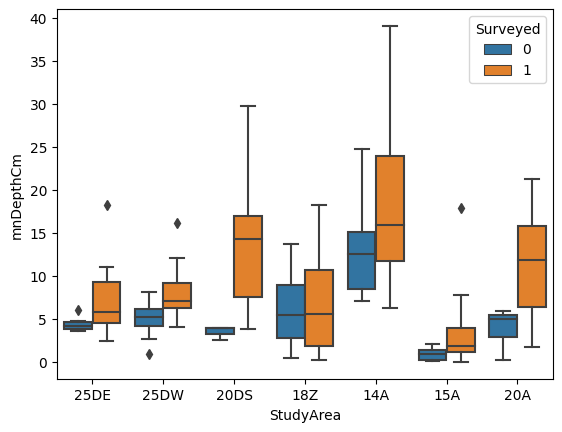

In [18]:
# create grouped boxplot
sns.boxplot(x = gdf['StudyArea'],
           y = gdf['mnDepthCm'],
           hue = gdf['Surveyed'])

## Multivariate Logistic Regession Analysis with statsmodels
This notebook is a brief demonstration of collaborative analysis so I do not attempt a full model selection process. Here I demonstrate using the **statsmodels** package to perform a relatively simple logistic regression with snow depth and GMU (game management unit) as explanatory variables for survey outcome:
$$
logit(y) = \beta_0 + \beta_1*SnowDepth_1 + \beta_2*GMU_2
$$
 Where *y* is the probability of adequate survey conditions to launch a survey (0 or 1) and $\beta$s are the fixed-effect regression coefficients.
 I use GMU instead of study area because study areas 25DE and 25DW are adjacent and use the same SNOWMODEL raster for snow depth.

In [20]:
# logistic regression

formula = 'Surveyed ~ mnDepthCm + GMU'
snow_fit = glm(formula=formula, data=gdf,
            family=sm.families.Binomial()).fit()
print(snow_fit.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:               Surveyed   No. Observations:                  170
Model:                            GLM   Df Residuals:                      163
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -79.047
Date:                Wed, 15 Mar 2023   Deviance:                       158.09
Time:                        14:09:11   Pearson chi2:                     168.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1605
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3224      0.923     -2.517      0.0

## Evaluating Regression
### Looking for multicolinearity among variables
Usually, several diagnostics are performed to ensure that model assumptions are upheld. One analysis is to examine colinearity among explanatory variables. I used **numpy** to calculate and display a basic correlation matrix after converting the GMU levels to dummy variables. There was some colinearity between snow depth and GMU 14A, snow depth and GMU 15A. 

In [21]:
# correlation matrix in numpy

X = pd.get_dummies(gdf[['mnDepthCm', 'GMU', 'Year']])
X.corr(method='spearman')

,mnDepthCm,Year,GMU_14A,GMU_15A,GMU_18Z,GMU_20A,GMU_20D,GMU_25D
mnDepthCm,1.000000,-0.270916,0.412402,-0.506234,-0.099852,0.101827,0.235265,-0.112781
Year,-0.270916,1.000000,0.000169,0.015887,0.029884,0.036257,0.025705,-0.083550
GMU_14A,0.412402,0.000169,1.000000,-0.192213,-0.124391,-0.180426,-0.184383,-0.252903
GMU_15A,-0.506234,0.015887,-0.192213,1.000000,-0.138675,-0.201146,-0.205557,-0.281945
GMU_18Z,-0.099852,0.029884,-0.124391,-0.138675,1.000000,-0.130171,-0.133026,-0.182461
GMU_20A,0.101827,0.036257,-0.180426,-0.201146,-0.130171,1.000000,-0.192952,-0.264656
GMU_20D,0.235265,0.025705,-0.184383,-0.205557,-0.133026,-0.192952,1.000000,-0.270460
GMU_25D,-0.112781,-0.083550,-0.252903,-0.281945,-0.182461,-0.264656,-0.270460,1.000000


However, GMU isn't a great fit as an explanation for survey outcome. Rather, it should be included to allow different a model intercept for each relationship between survey outcome and snow depth among the different GMUs. Based on the boxplot earlier, this may be the case. For this type of analysis, we need a logistic mixed model- which can't be done in the statsmodels package.

## Regression Analysis with pymer4: generalized linear model with logit & random effect

We want to model the probability of adequate snow conditions for conducting moose surveys based on 01 Nov snow depth. In this model, I include GMU as a random effect because the relationship between survey outcome and snow depth could have a different intercept for the different GMUs. This could be because snow depth predictions were biased high or low relative to other areas, or biologists in GMUs using different thresholds for snow depth when deciding to do a survey.

$$
logit(y) = \beta_0 + \beta_1*SnowDepth_1 + Z*GMU
$$
Where *y* is the probability of adequate survey conditions to launch a survey (0 or 1), $\beta$s is the SNOWMODEL averaged snow depth and *Z* is the design matrix containing 1 random effect(GMU).
I used [this article](https://towardsdatascience.com/how-to-run-linear-mixed-effects-models-in-python-jupyter-notebooks-4f8079c4b589) by Jin Cheong to get started.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: Surveyed~mnDepthCm+(1|GMU)

Family: binomial	 Inference: parametric

Number of observations: 170	 Groups: {'GMU': 6.0}

Log-likelihood: -85.595 	 AIC: 177.191

Random effects:

            Name    Var   Std
GMU  (Intercept)  0.409  0.64

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.043,-0.997,0.911,0.487,0.958,0.369,2.487,0.489,0.270,0.713,-0.088,0.930,
mnDepthCm,0.170,0.059,0.282,0.057,1.186,1.061,1.326,0.542,0.515,0.570,2.995,0.003,**


SS Type III Analysis of Variance Table with Satterthwaite approximated degrees of freedom:
(NOTE: Using original model contrasts, orthogonality not guaranteed)


,DF,SS,MS,F-stat
mnDepthCm,1,12.869256,12.869256,12.869256


<AxesSubplot: xlabel='fits', ylabel='Surveyed'>

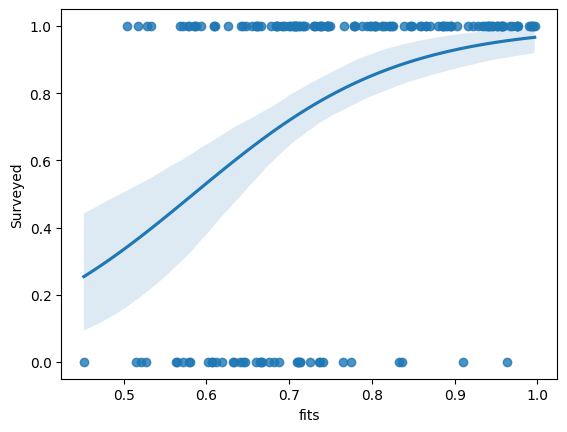

In [22]:
## Regression Analysis
model = Lmer("Surveyed ~ mnDepthCm + (1|GMU)", data=gdf, family='binomial')

display(model.fit())
display(model.anova())

sns.regplot(x='fits', y = 'Surveyed', data=model.data, fit_reg=True, logistic=True)

This is demonstrates the Python code needed to produce a basic model, but a more complete analysis is needed. This earmarks the python code for a much more involved analysis, including splitting the data into training and prediction, testing assumptions, and plotting. 

## Regression Analysis Using statsmodels: Bayesian approach with random effect 
This approach uses the statsmodels python package for analysis and matplotlib & seaborn for plots. [This Kaggle notebook](https://www.kaggle.com/code/ojwatson/mixed-models) by O. J. Watson and [This article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3866838/) by Capanu et al. provided guidance for conducting a binary (logistic) Bayesian generalized linear mixed model analysis using [statsmodels.BionomialBayesMixedGLM](https://www.statsmodels.org/stable/generated/statsmodels.genmod.bayes_mixed_glm.BinomialBayesMixedGLM.html#statsmodels.genmod.bayes_mixed_glm.BinomialBayesMixedGLM). 
I have no experience with Bayesian statistics and cannot interpret the model output. However, this is the only option for conducting a logistic mixed model using statsmodels, in case one of my colleagues wants to go down this road.

In [23]:
random = {'GMU': '0 + C(GMU)'}
model = BinomialBayesMixedGLM.from_formula('Surveyed ~ mnDepthCm', random, data=gdf)
result = model.fit_vb()
print(result.summary())

               Binomial Mixed GLM Results
          Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
--------------------------------------------------------
Intercept    M    -0.0952   0.1914                      
mnDepthCm    M     0.1835   0.0253                      
GMU          V    -0.2513   0.2829 0.778   0.442   1.369
Parameter types are mean structure (M) and variance
structure (V)
Variance parameters are modeled as log standard
deviations


### Conclusion
Datacamp Workspace provided a great solution for collaborating on this analysis. It is not the only cloud-based platform for running Jupyter Notebooks (Google Colab holds promise). Datacamp does a great job, but there is a price tag, which grows substantially as you migrate to a "Teams" type platform with many contributors. Tf this is your day job, it might be worth the investment.